## Import Libraries and Data

In [6]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Deep Learning Libraries
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Add, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import F1Score

# File Handling
import joblib




## Preprocessing
In the preprocessing step, we define the categorical and numerical columns that we intend to process further.

- **Target column**: The **obesity category (NObeyesdad)** is the target feature we want to predict in this case (e.g., normal weight, overweight level I, etc.).

- **Categorical features**: We apply **one-hot encoding** including target column (by using <code>to_categorical</code>) instead of label encoding since deep learning models are capable of handling high-dimensional data efficiently.

- **Numerical features**: We apply **standardization** by subtracting the mean and dividing by the standard deviation for each feature. This ensures that no single feature disproportionately influences the model due to scale differences.

Finally, we split the dataset into a **20% test set**, **~10% validation set** and an **~70% training set**, which is a typical ratio used in machine learning.

In [22]:
DATA_PATH = 'data/train.csv'

df = pd.read_csv(DATA_PATH)
df = df.drop('id', axis=1)
print(f'Sample size: {len(df)}, Data shape: {df.shape}')
df.head()


Sample size: 20758, Data shape: (20758, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [23]:
def preprocess_data(df, target_column='NObeyesdad', mode='train', encoder_path=None, label_encoder_path=None):
    categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
    numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
    
    numerical_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ])

    if mode == 'train':
        if target_column in df.columns:
            le = LabelEncoder()
            y = le.fit_transform(df[target_column])
            y = to_categorical(y, num_classes=len(le.classes_))
            X = df.drop(target_column, axis=1)
            print(f'🎯 Target: {target_column} | Classes: {le.classes_}')

            # Fit and transform
            X_transformed = preprocessor.fit_transform(X)

            # Show classes per categorical feature
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            for feature, categories in zip(categorical_columns, ohe.categories_):
                print(f'📊 Feature: {feature} | Classes: {list(categories)}')

            # Save the preprocessor and label encoder
            joblib.dump(preprocessor, encoder_path)
            joblib.dump(le, label_encoder_path)
        else:
            y = None
            X = df
            X_transformed = preprocessor.fit_transform(X)
            joblib.dump(preprocessor, encoder_path)
    else:
        # Load the saved preprocessor and label encoder
        preprocessor = joblib.load(encoder_path)
        le = joblib.load(label_encoder_path)
        y = None if target_column not in df.columns else to_categorical(le.transform(df[target_column]), num_classes=len(le.classes_))
        X = df.drop(target_column, axis=1) if target_column in df.columns else df
        X_transformed = preprocessor.transform(X)

    return (X_transformed, y, le) if target_column in df.columns else (X_transformed)

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

X_train, y_train, label_encoder = preprocess_data(df_train, target_column='NObeyesdad', mode='train', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
X_test, y_test, _ = preprocess_data(df_test, target_column='NObeyesdad', mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
X_val, y_val, _ = preprocess_data(df_val, target_column='NObeyesdad', mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')

print()
print(f'X_train shape before: {df_train.shape} -> after transformation: {X_train.shape}')
print(f'X_test shape before: {df_test.shape} -> after transformation: {X_test.shape}')
print(f'X_val shape before: {df_val.shape} -> after transformation: {X_val.shape}')

🎯 Target: NObeyesdad | Classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
📊 Feature: Gender | Classes: ['Female', 'Male']
📊 Feature: family_history_with_overweight | Classes: ['no', 'yes']
📊 Feature: FAVC | Classes: ['no', 'yes']
📊 Feature: CAEC | Classes: ['Always', 'Frequently', 'Sometimes', 'no']
📊 Feature: SMOKE | Classes: ['no', 'yes']
📊 Feature: SCC | Classes: ['no', 'yes']
📊 Feature: CALC | Classes: ['Frequently', 'Sometimes', 'no']
📊 Feature: MTRANS | Classes: ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']

X_train shape before: (14530, 17) -> after transformation: (14530, 30)
X_test shape before: (4152, 17) -> after transformation: (4152, 30)
X_val shape before: (2076, 17) -> after transformation: (2076, 30)


In [7]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)

model = Sequential([
    Input(shape=(30,)),
    Dense(128, activation="relu", kernel_initializer=HeUniform()),
    Dropout(0.2),
    Dense(64, activation="relu", kernel_initializer=HeUniform()),
    Dense(7, activation="softmax")
])
model.summary()
model.compile(optimizer=Adam(learning_rate=lr_schedule), 
              loss="categorical_crossentropy", 
              metrics=[F1Score(average='weighted', name='f1_score'),
                       "accuracy"])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,679 (49.53 KB)

 Trainable params: 12,679 (49.53 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callback = EarlyStopping(monitor='val_f1_score', patience=5, min_delta=1e-3, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=32,
          callbacks=[callback])
model.save('../../models/obesity_model.keras')

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2579 - f1_score: 0.2369 - loss: 2.0430 - val_accuracy: 0.6108 - val_f1_score: 0.5814 - val_loss: 1.1178
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5780 - f1_score: 0.5575 - loss: 1.1302 - val_accuracy: 0.6633 - val_f1_score: 0.6396 - val_loss: 0.8707
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6512 - f1_score: 0.6359 - loss: 0.9068 - val_accuracy: 0.7100 - val_f1_score: 0.6965 - val_loss: 0.7568
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6800 - f1_score: 0.6700 - loss: 0.8102 - val_accuracy: 0.7399 - val_f1_score: 0.7308 - val_loss: 0.6823
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7120 - f1_score: 0.7045 - loss: 0.7327 - val_accuracy: 0.7640 - val_f1_score: 0.7554 - val_loss: 0.6289
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.7295 - f1_score: 0.7234 - loss: 0.6850 - val_accuracy: 0.7828 - val_f1

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8708 - f1_score: 0.8707 - loss: 0.3696
Test Loss: 0.3778
Test F1 Score: 0.8653
Test Accuracy: 86.58%
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
['Obesity_Type_III' 'Overweight_Level_I' 'Obesity_Type_I' ...
 'Obesity_Type_I' 'Overweight_Level_I' 'Overweight_Level_II']


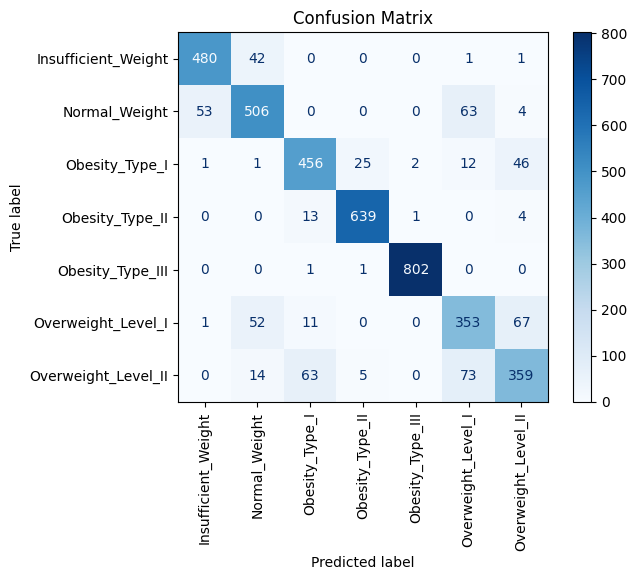

In [9]:
loss, f1_score, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize the predictions
y_pred_temp = model.predict(X_test)
y_pred_temp = np.argmax(y_pred_temp, axis=1)
y_pred_temp = label_encoder.inverse_transform(y_pred_temp)

y_test_temp = np.argmax(y_test, axis=1)
y_test_temp = label_encoder.inverse_transform(y_test_temp)
print(y_test_temp)

cm = confusion_matrix(y_test_temp, y_pred_temp)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [11]:
def predict(input):
    model = load_model('../../models/obesity_model.keras')

    # Check model, encoder, and label encoder existence
    PREPROCESSOR_PATH = 'obesity_preprocessor.pkl'
    LABEL_ENCODER_PATH = 'obesity_label_encoder.pkl'
    if not model:
        raise Exception("Model not found.")
    if not joblib.load(PREPROCESSOR_PATH):
        raise Exception("Encoder not found.")
    if not joblib.load(LABEL_ENCODER_PATH):
        raise Exception("Label encoder not found.")
    
    input = pd.DataFrame([input])
    input_transformed = preprocess_data(input, target_column=None, mode='test', encoder_path='obesity_preprocessor.pkl', label_encoder_path='obesity_label_encoder.pkl')
    y_pred_temp = model.predict(input_transformed)
    y_pred_temp = np.argmax(y_pred_temp, axis=1)
    y_pred_temp = label_encoder.inverse_transform(y_pred_temp)
    return y_pred_temp[0]

# Example usage
input = {
    "Gender": "Male",
    "Age": 24.443011,
    "Height": 1.699998,
    "Weight": 81.66995,
    "family_history_with_overweight": "yes",
    "FAVC": "yes",
    "FCVC": 2.7,
    "CAEC": "Sometimes",
    "NCP": 2.983297,
    "CH2O": 2.763573,
    "SMOKE": "no",
    "SCC": "no",
    "FAF": 0,
    "TUE": 0.976473,
    "CALC": "Sometimes",
    "MTRANS": "Public_Transportation"
}
print(predict(input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Overweight_Level_II


# UMAP Layer Visualization

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


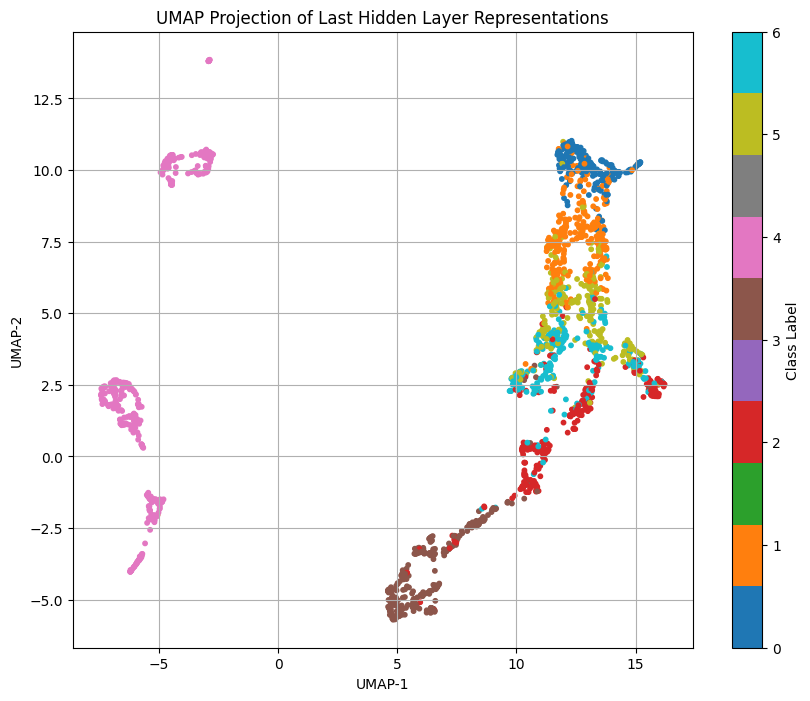

In [25]:
from tensorflow.keras.models import load_model, Model
from keras.metrics import F1Score
from tensorflow.keras.layers import Input
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# 1. Load the trained model
trained_model = load_model('../../models/obesity_model.keras', custom_objects={'F1Score': F1Score})

# 2. Get input shape safely from the model itself (not from a layer)
input_shape = trained_model.input_shape[1:]  # excludes batch dimension

# 3. Rebuild up to the last hidden layer
inp = Input(shape=input_shape)
x = inp
for layer in trained_model.layers[:-1]:  # exclude last layer (softmax)
    x = layer(x)
hidden_layer_model = Model(inputs=inp, outputs=x)

# 4. Get the hidden representations
hidden_output = hidden_layer_model.predict(X_val)

# 5. Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(hidden_output)

# 6. Visualize
y_val_labels = np.argmax(y_val, axis=1)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_val_labels, cmap='tab10', s=10)
plt.colorbar(scatter, label='Class Label')
plt.title('UMAP Projection of Last Hidden Layer Representations')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


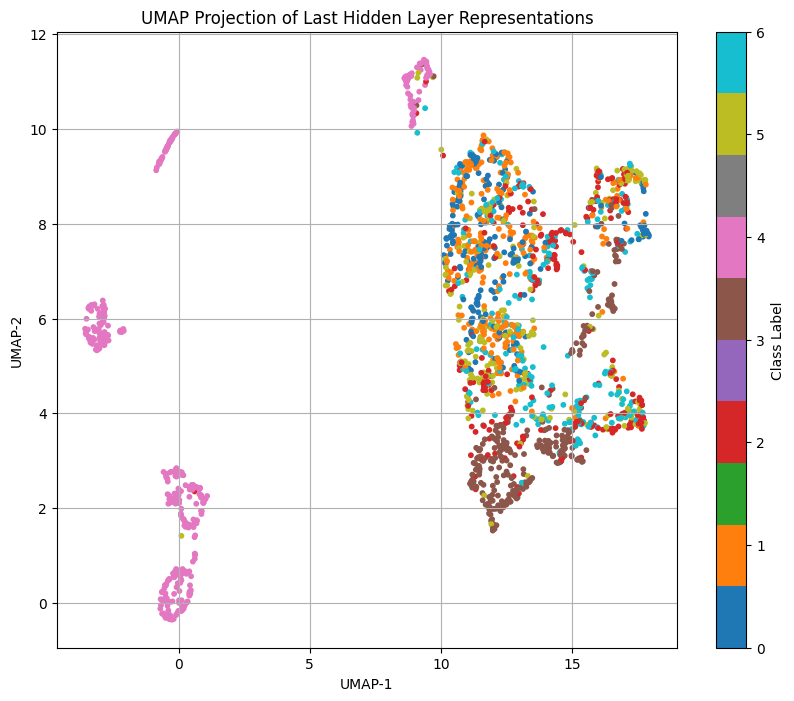

In [26]:
from tensorflow.keras.models import load_model, Model
from keras.metrics import F1Score
from tensorflow.keras.layers import Input
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# 1. Load the trained model

# 2. Get input shape safely from the model itself (not from a layer)
input_shape = model.input_shape[1:]  # excludes batch dimension

# 3. Rebuild up to the last hidden layer
inp = Input(shape=input_shape)
x = inp
for layer in model.layers[:-1]:  # exclude last layer (softmax)
    x = layer(x)
hidden_layer_model = Model(inputs=inp, outputs=x)

# 4. Get the hidden representations
hidden_output = hidden_layer_model.predict(X_val)

# 5. Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(hidden_output)

# 6. Visualize
y_val_labels = np.argmax(y_val, axis=1)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_val_labels, cmap='tab10', s=10)
plt.colorbar(scatter, label='Class Label')
plt.title('UMAP Projection of Last Hidden Layer Representations')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.show()